In [2]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("datasnaek/mbti-type")

# Check the downloaded dataset path
print("Path to dataset files:", path)

# Assuming the dataset contains a CSV file, find and read it
for file in os.listdir(path):
    if file.endswith(".csv"):
        dataset_path = os.path.join(path, file)
        break
else:
    raise FileNotFoundError("No CSV file found in the downloaded dataset.")

# Load the dataset
df = pd.read_csv(dataset_path)

# Display the first few rows
print(df.head())


# In[5]:


dimensions = df.shape
dimensions




# In[6]:


import pandas as pd

# Preprocess the MBTI labels (convert to numerical encoding)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["label_mbti"] = label_encoder.fit_transform(df["type"])

labels = df["label_mbti"].tolist()
num_classes = len(label_encoder.classes_)
num_classes



# In[8]:


import string
import re

def clean_text(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = [i for i in words if not "http" in i]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    return words


# In[9]:


df["cleaned_text"] = df["posts"].apply(clean_text)





# In[10]:


texts = df["cleaned_text"].tolist()
max(len(text) for text in texts)


# In[11]:


from transformers import BertTokenizer

# Load pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Path to dataset files: /nas/longleaf/home/longfeiz/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1
   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from transformers import TFBertModel, BertTokenizer
from transformers import BertConfig
# Load pre-trained BERT model and tokenizer

Num GPUs Available:  1


In [5]:
import tensorflow as tf
from transformers import BertConfig, TFBertModel
tf.keras.backend.clear_session()
# Define BERT configuration and model
# config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.15, attention_probs_dropout_prob=0.1)
bert_model = TFBertModel.from_pretrained("bert-base-uncased")#, config=config)
bert_model.trainable = True
# Define max sequence length
max_length = 512

# Define a custom Keras layer for the BERT model
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model):
        super(BertLayer, self).__init__()
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output  # Return only the pooler_output as a tensor

# Define input layers
input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Pass inputs through the custom BERT layer
bert_output = BertLayer(bert_model)([input_ids, attention_mask])

# Add classification layers
# dense = tf.keras.layers.Dense(32, activation="relu")(bert_output)
output = tf.keras.layers.Dense(16, activation="softmax")(bert_output)  # Assuming 16 MBTI classes

# Create the full model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",  # Apply Focal Loss
    metrics=["accuracy"]
)

# Display the model summary
model.summary()

I0000 00:00:1733260154.929804  836562 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38487 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_layer (BertLayer)      (None, 768)                  1094822   ['input_ids[0][0]',           
                                                          40         'attention_mask[0][0]']      
                                                                                              

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Split the data into train and validation sets
X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    df["cleaned_text"].values,
    df["type"].values,
    test_size=0.2,
    random_state=42
)

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Preprocess the data
def preprocess(texts, tokenizer):
    return tokenizer(
        list(texts),
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )

# Tokenize train and validation data
train_encodings = preprocess(X_train_texts, tokenizer)
val_encodings = preprocess(X_val_texts, tokenizer)

In [7]:
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
label_encoder.fit(df["type"].unique())  # Fit on all unique MBTI labels in the dataset

# Encode string labels into integers
y_train = label_encoder.transform(y_train)  # Transform training labels
y_val = label_encoder.transform(y_val)      # Transform validation labels
# Convert to one-hot encoded format
num_classes = len(label_encoder.classes_)  # Determine the number of unique MBTI types
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# If `y_train` is one-hot encoded, convert it back to integer labels
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_flat = np.argmax(y_train, axis=1)  # Convert one-hot to integers
else:
    y_train_flat = y_train

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_flat),
    y=y_train_flat
)

# Convert to dictionary format required by Keras
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(2.911073825503356), 1: np.float64(0.7886363636363637), 2: np.float64(2.31951871657754), 3: np.float64(0.7886363636363637), 4: np.float64(12.392857142857142), 5: np.float64(10.84375), 6: np.float64(13.5546875), 7: np.float64(5.861486486486487), 8: np.float64(0.3669627749576988), 9: np.float64(0.2966826265389877), 10: np.float64(0.48301781737193766), 11: np.float64(0.4290306627101879), 12: np.float64(3.584710743801653), 13: np.float64(1.989678899082569), 14: np.float64(2.6940993788819876), 15: np.float64(1.6064814814814814)}


In [9]:
with tf.device('/GPU:0'):
    history = model.fit(
        [train_encodings["input_ids"], train_encodings["attention_mask"]],
        y_train,  # Use one-hot encoded labels
        validation_data=(
            [val_encodings["input_ids"], val_encodings["attention_mask"]],
            y_val
        ),
        batch_size=16,
        epochs=13,
        class_weight=class_weight_dict  # Pass the computed class weights
    )

Epoch 1/13


I0000 00:00:1733260343.443903  836658 service.cc:148] XLA service 0x7fef052f16e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733260343.443933  836658 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-12-03 16:12:23.450112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733260343.470552  836658 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733260343.568527  836658 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


434/434 [==============================] - 140s 249ms/step - loss: 2.8359 - accuracy: 0.0352 - val_loss: 2.7989 - val_accuracy: 0.0784
Epoch 2/13
434/434 [==============================] - 106s 244ms/step - loss: 2.6537 - accuracy: 0.1236 - val_loss: 2.2921 - val_accuracy: 0.3493
Epoch 3/13
434/434 [==============================] - 106s 243ms/step - loss: 1.9507 - accuracy: 0.4437 - val_loss: 1.9368 - val_accuracy: 0.4622
Epoch 4/13
434/434 [==============================] - 106s 244ms/step - loss: 1.5209 - accuracy: 0.5542 - val_loss: 1.6420 - val_accuracy: 0.5401
Epoch 5/13
434/434 [==============================] - 106s 243ms/step - loss: 1.2345 - accuracy: 0.6056 - val_loss: 1.5615 - val_accuracy: 0.5769
Epoch 6/13
434/434 [==============================] - 105s 243ms/step - loss: 0.9950 - accuracy: 0.6491 - val_loss: 1.5278 - val_accuracy: 0.5781
Epoch 7/13
434/434 [==============================] - 105s 243ms/step - loss: 0.8110 - accuracy: 0.6869 - val_loss: 1.4403 - val_accura

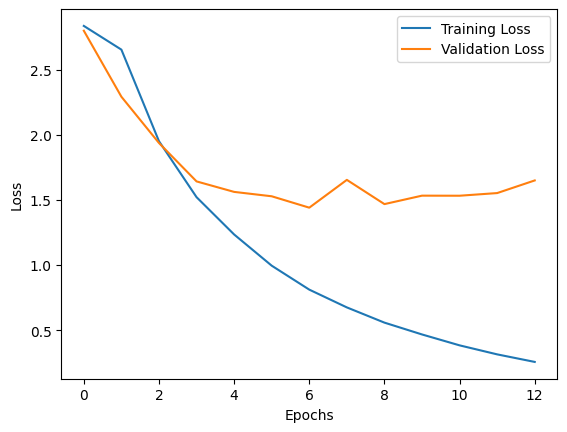

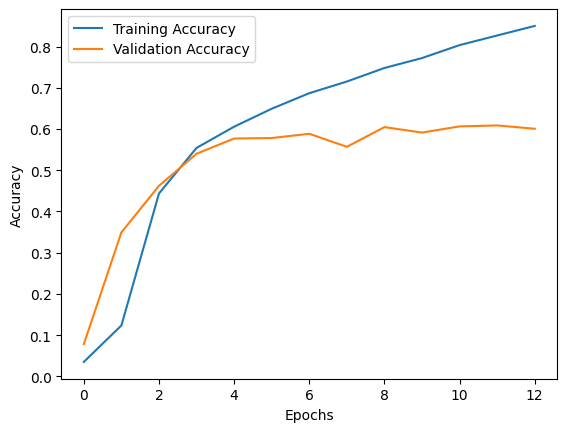

In [12]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('training_validation_loss_drop.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()
plt.close()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('training_validation_acc_drop.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()
plt.close()

In [14]:
# Evaluate on val data
loss, accuracy = model.evaluate(
    [val_encodings["input_ids"], val_encodings["attention_mask"]],
    y_val
)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

55/55 [==============================] - 8s 143ms/step - loss: 1.6494 - accuracy: 0.6006
Validation Loss: 1.6494112014770508
Validation Accuracy: 0.6005763411521912


In [ ]:
# insert text here
sample_texts = [" "]
ssample_texts = [clean_text(text) for text in sample_texts]  # or use map(clean_text, sample_texts)
inputs = tokenizer(
    sample_texts,
    max_length=max_length,
    padding="max_length",
    truncation=True,
    return_tensors="tf"
)

# Prediction results
predictions = model.predict([inputs["input_ids"], inputs["attention_mask"]])
predicted_classes = np.argmax(predictions, axis=1)
decoded_labels = label_encoder.inverse_transform(predicted_classes)
print(decoded_labels)